# Udemy Best Sellers

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 500)

In [3]:
RANDOM_STATE = 101

## EDA

In [4]:
df_raw = pd.read_parquet('../data/udemy_entrenamiento.parquet', engine="pyarrow")

In [5]:
df_raw.head(2)

,id,title,headline,is_practice_test_course,bestseller,captions,rating,num_published_lectures,num_published_practice_tests,locale,created_date,instructional_level_simple,published_date,last_update_date,content_info_short,instructors,category,subcategory,objectives,list_price,discount_price
0,1,Aprende a tocar Piano o Teclado (Desde nivel b...,Curso completo de Piano con TEORÍA para el fun...,False,no,es_LA,4.535809,58,1,es_LA,2012-01-26,Todos los niveles,2012-01-26,2021-05-19,4 horas,121211,Música,Piano,Aprende Piano desde nivel básico. Estudiaras l...,$34.99,$12
1,2,Curso Hipoterapia y Rehabilitacion Ecuestre On...,"Terapias asistidas por Caballos (Hipoterapia, ...",False,no,es_ES,4.133590,32,0,es_ES,2012-06-10,Principiante,2012-06-10,2015-12-17,10 horas,236127,Estilo de vida,Adiestramiento de mascotas,La Hipoterapia y la Psicología.La Hipoterapia ...,$99.99,None


In [118]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11087 entries, 0 to 11086
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            11087 non-null  int64  
 1   title                         11087 non-null  object 
 2   headline                      11086 non-null  object 
 3   is_practice_test_course       11087 non-null  bool   
 4   bestseller                    11087 non-null  object 
 5   captions                      9142 non-null   object 
 6   rating                        11087 non-null  float64
 7   num_published_lectures        11087 non-null  int64  
 8   num_published_practice_tests  11087 non-null  int64  
 9   locale                        11087 non-null  object 
 10  created_date                  11087 non-null  object 
 11  instructional_level_simple    11082 non-null  object 
 12  published_date                11087 non-null  object 
 13  l

In [94]:
round(df_raw.isnull().sum().to_frame('% nulls') / len(df_raw) * 100, 2)

,% nulls
id,0.00
title,0.00
headline,0.01
is_practice_test_course,0.00
bestseller,0.00
captions,17.54
rating,0.00
num_published_lectures,0.00
num_published_practice_tests,0.00
locale,0.00


In [8]:
def preprocess(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe = dataframe.drop(['id'], axis=1)
    
    dataframe['list_price'] = dataframe['list_price'].str.replace('$','')
    
    dataframe['discount_price'] = dataframe['discount_price'].fillna('0.0')
    dataframe['discount_price'] = dataframe['discount_price'].str.replace('$','')
    
    #Get dummies
    one_hot = pd.get_dummies(dataframe['locale'])
    # data_df = dataframe.drop('vehicleType',axis = 1)
    dataframe = dataframe.join(one_hot)
        
    dataframe = dataframe.astype({'list_price': float, 'discount_price': float})
    
    dataframe['bestseller'] = dataframe['bestseller'].map({'no': 0, 'si':1})
    dataframe['is_practice_test_course'] = dataframe['is_practice_test_course'].map({False: 0, True:1})
    
    return dataframe

In [9]:
df_training = preprocess(df_raw)

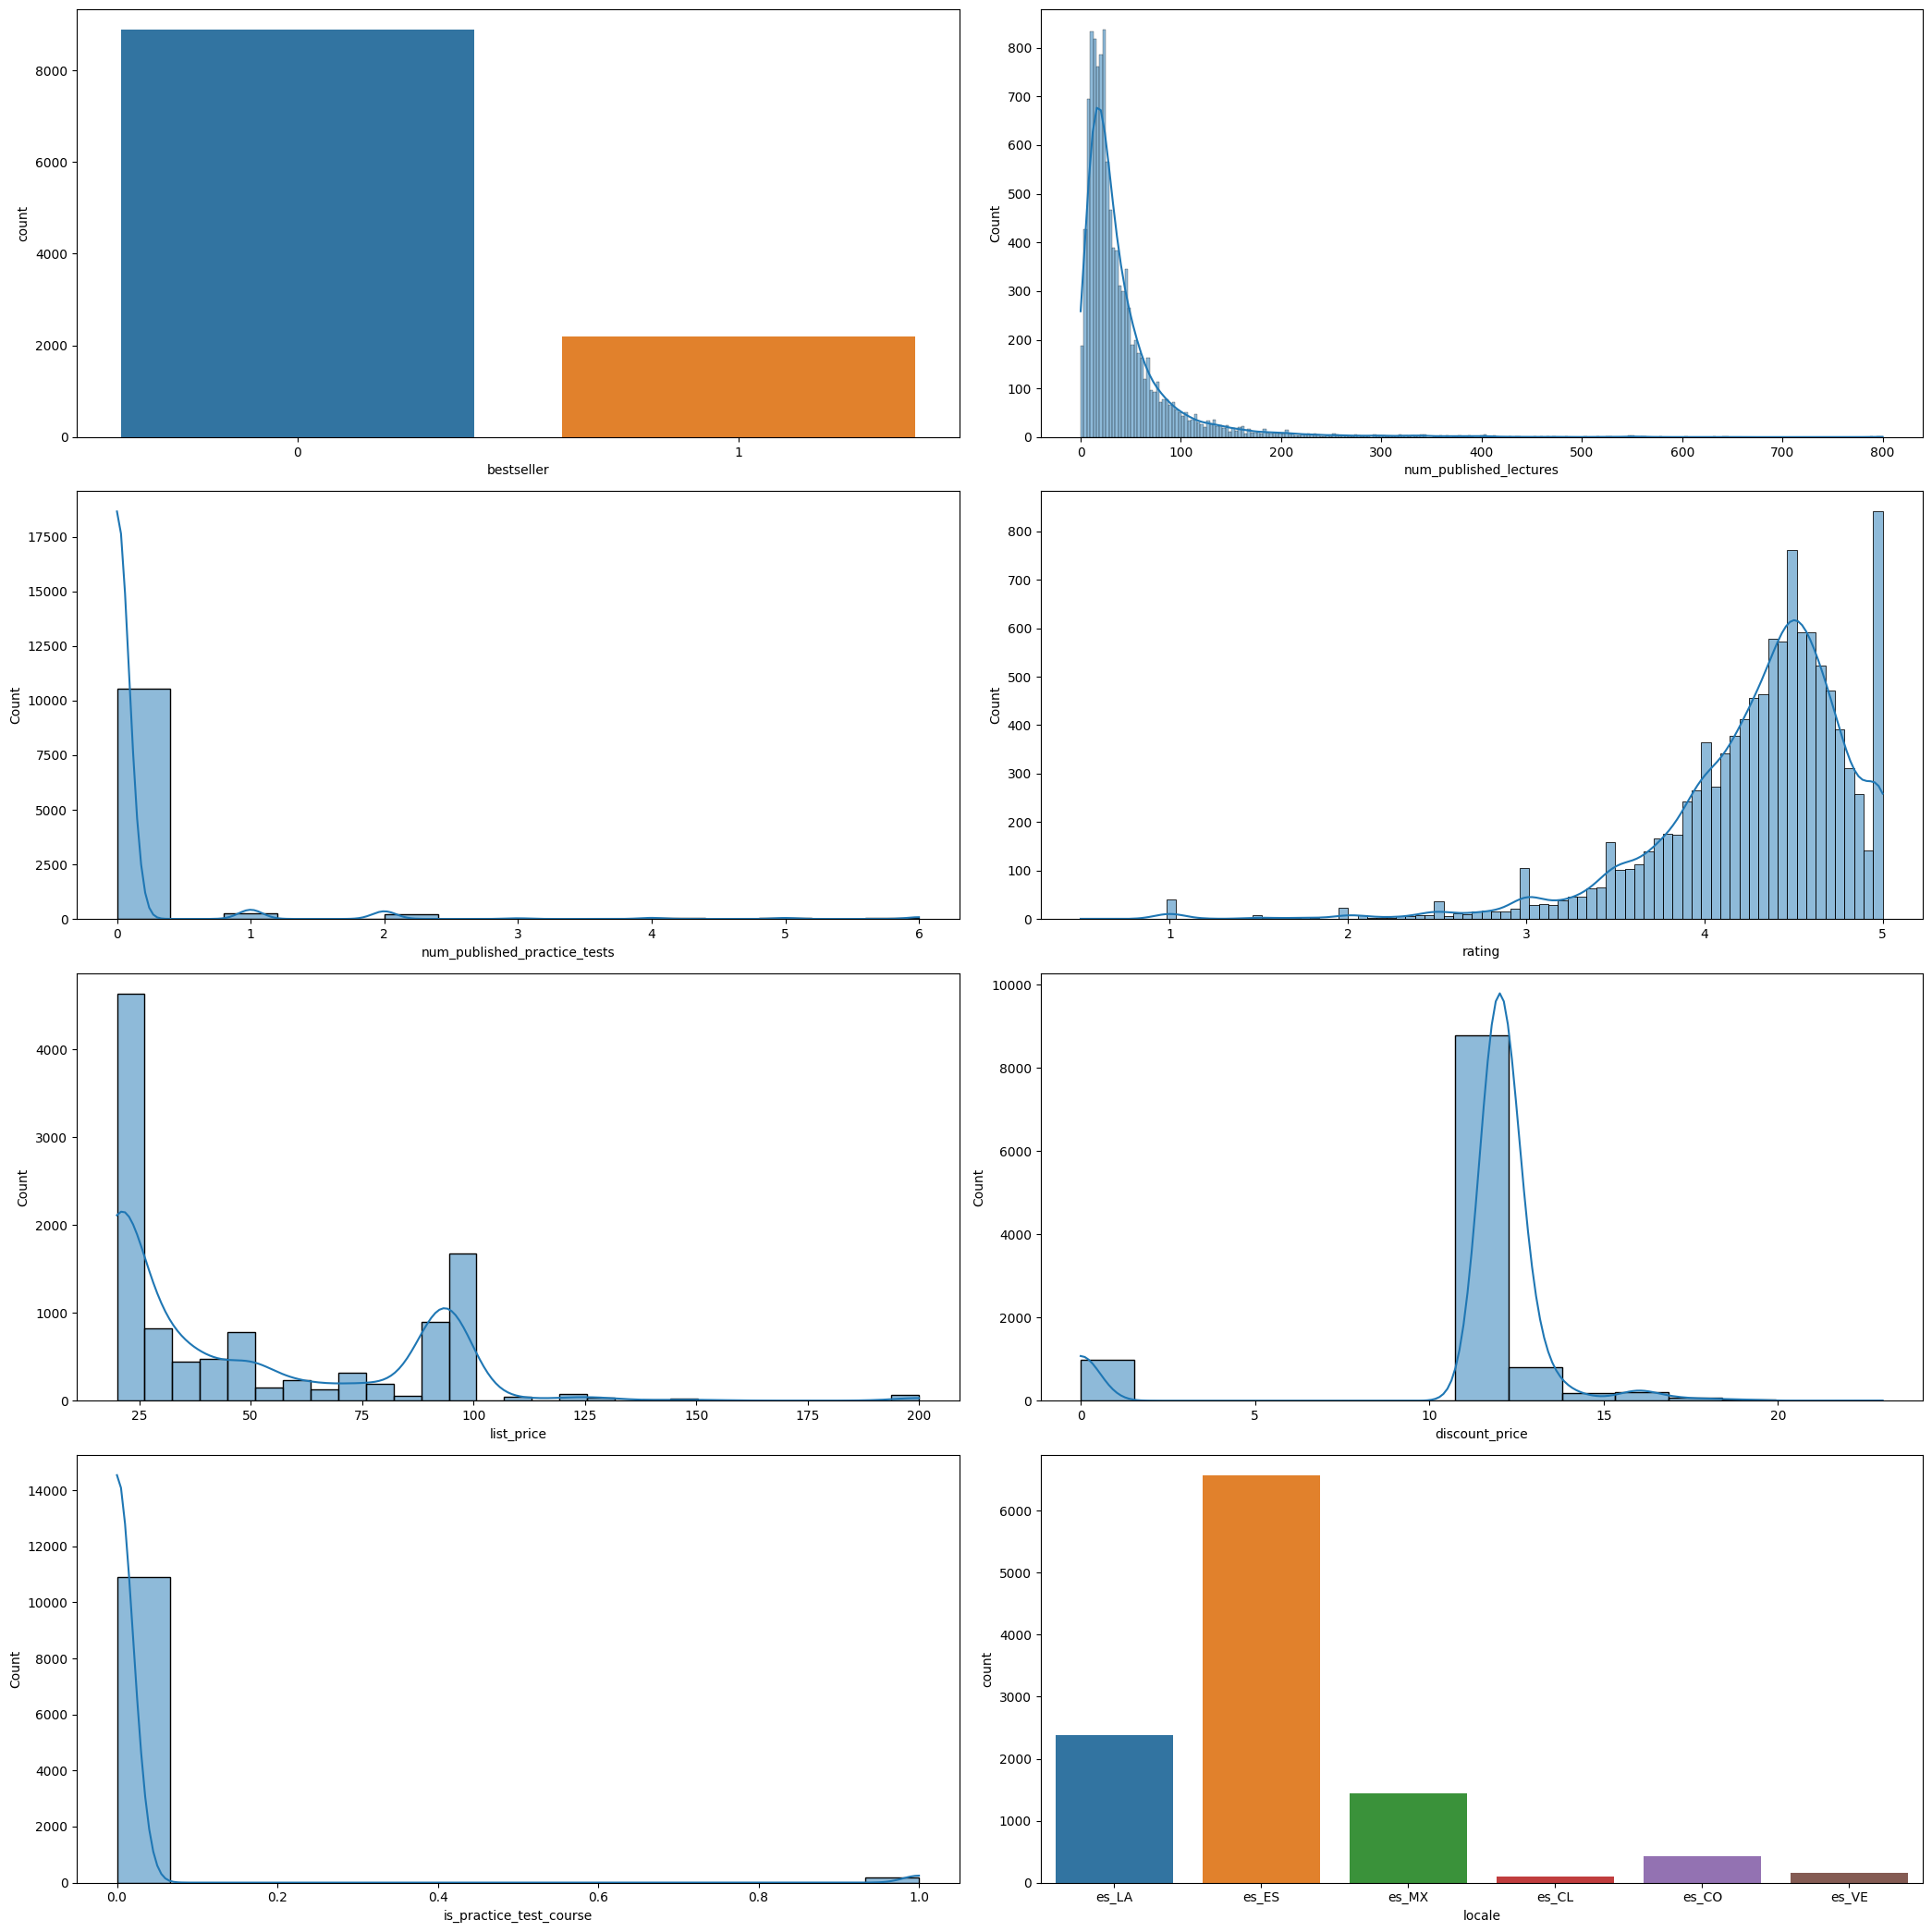

In [124]:
fig, axes = plt.subplots(4,2,figsize=(21,21))
sns.countplot(data=df_training, x='bestseller', ax=axes[0,0])
sns.histplot(data=df_training, x='num_published_lectures', kde=True, ax=axes[0,1])
sns.histplot(data=df_training, x='num_published_practice_tests', kde=True, ax=axes[1,0])
sns.histplot(data=df_training, x='rating', kde=True, ax=axes[1,1])
sns.histplot(data=df_training, x='list_price', kde=True, ax = axes[2,0])
sns.histplot(data=df_training, x='discount_price', kde=True, ax = axes[2,1])
sns.histplot(data=df_training, x='is_practice_test_course', kde=True, ax = axes[3,0])
sns.countplot(data=df_training, x='locale', ax = axes[3,1])

plt.tight_layout()
plt.show()

### Conclusions

- Target variable is unbalanced
- 

## Base line model

In [11]:
df_training.head()

,title,headline,is_practice_test_course,bestseller,captions,rating,num_published_lectures,num_published_practice_tests,locale,created_date,instructional_level_simple,published_date,last_update_date,content_info_short,instructors,category,subcategory,objectives,list_price,discount_price,es_CL,es_CO,es_ES,es_LA,es_MX,es_VE
0,Aprende a tocar Piano o Teclado (Desde nivel b...,Curso completo de Piano con TEORÍA para el fun...,0,0,es_LA,4.535809,58,1,es_LA,2012-01-26,Todos los niveles,2012-01-26,2021-05-19,4 horas,121211,Música,Piano,Aprende Piano desde nivel básico. Estudiaras l...,34.99,12.0,False,False,False,True,False,False
1,Curso Hipoterapia y Rehabilitacion Ecuestre On...,"Terapias asistidas por Caballos (Hipoterapia, ...",0,0,es_ES,4.133590,32,0,es_ES,2012-06-10,Principiante,2012-06-10,2015-12-17,10 horas,236127,Estilo de vida,Adiestramiento de mascotas,La Hipoterapia y la Psicología.La Hipoterapia ...,99.99,0.0,False,False,True,False,False,False
2,Curso SEO Online,Curso SEO práctico. Aprenda a posicionar su si...,0,0,es_ES,3.841912,76,0,es_ES,2011-06-13,Todos los niveles,2012-07-03,2020-02-28,"6,5 horas",3851,Marketing,SEO,Entender los fundamentos del SEO.Aprender a ha...,94.99,12.0,False,False,True,False,False,False
3,Aprende CSS3 sin dolor,"Realiza animaciones asombrosas, antes imposibl...",0,0,es_MX,4.039739,68,0,es_MX,2012-08-30,Intermedio,2012-08-31,2019-09-08,"9,5 horas",171706,Desarrollo,CSS,El alumno conocerá las principales característ...,19.99,12.0,False,False,False,False,True,False
4,"Aprende Javascript, HTML5 y CSS3",Aprende los principales lenguajes que dominan ...,0,1,None,4.643154,550,0,es_MX,2012-08-30,Todos los niveles,2012-09-02,2021-03-04,"70,5 horas",171706,Desarrollo,JavaScript,"Desarrollar páginas dinámicas con JavaScript, ...",29.99,12.0,False,False,False,False,True,False


In [12]:
mlflow.sklearn.autolog()

In [13]:
clf = DecisionTreeClassifier(random_state=RANDOM_STATE)

In [14]:
df_training = df_training[
    ['bestseller', 
     'num_published_lectures', 
     'num_published_practice_tests',
     'rating',
     'list_price',
     'discount_price',
     'is_practice_test_course',
     'es_CL',
     'es_CO',
     'es_ES',
     'es_LA',
     'es_MX',
     'es_VE'
    ]
]

In [17]:
X, y = df_training.drop(['bestseller'], axis=1), df_training['bestseller']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [18]:
with mlflow.start_run() as run:
    clf.fit(X_train, y_train)

NameError: name 'model' is not defined

In [ ]:
df_test = pd.read_parquet('../data/udemy_prueba.parquet', engine="pyarrow")